In [3]:
import os
import numpy as np
import DataPreprocessing as DP
import itertools
import h5py
from matplotlib import pyplot as plt
from astropy.io import fits

from keras import backend as K
from keras.models import load_model
import tensorflow as tf

from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle

import glob

import time
Tstart = time.time() #Timer start

In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='XLA_GPU')
print(gpus)
tf.config.experimental.set_visible_devices(devices=gpus, device_type='XLA_GPU')

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]


In [5]:
lae_mfn = 'LAE_reconstruction2.0.h5'
nfeature = 5 #number of extracted features in each image
nCluster = 3 #number of obtained clusters
tosavemodel = True
savename = 'BGMM_model'

In [6]:
#Dataset
#norm spectrum
kinds = ['boss_cv','boss_da+ms','boss_db','boss_db+ms','boss_dq','boss_dz','fgkm','hotstars','wd','wdsb2','yso','hotstars_m']
flux_cv, spectrum_cv = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[0]+'/'+'*.fit')
flux_dams, spectrum_dams = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[1]+'/'+'*.fit')
flux_db, spectrum_db = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[2]+'/'+'*.fit')

#delate bad data
n = 0
for i in range(len(spectrum_db)):
    if len(spectrum_db[i][0]) < 4096:
        n = i
flux_db.pop(n)
spectrum_db.pop(n)

[array([5282.0195, 5283.235 , 5284.453 , 5285.669 , 5286.8877, 5288.104 ,
        5289.323 , 5290.54  , 5291.7573, 5292.9775, 5294.1953, 5295.416 ,
        5296.6343, 5297.8555, 5299.074 , 5300.2935, 5301.5156, 5302.7354,
        5303.958 , 5305.178 , 5306.4014, 5307.622 , 5308.8433, 5310.0674,
        5311.289 , 5312.5137, 5313.736 , 5314.9614, 5316.184 , 5317.407 ,
        5318.6333, 5319.857 , 5321.0835, 5322.3076, 5323.5347, 5324.76  ,
        5325.9844, 5327.213 , 5328.438 , 5329.667 , 5330.893 , 5332.122 ,
        5333.349 , 5334.5757, 5335.806 , 5337.0337, 5338.264 , 5339.492 ,
        5340.7236, 5341.952 , 5343.181 , 5344.413 , 5345.6426, 5346.8755,
        5348.1055, 5349.339 , 5350.5693, 5351.8003, 5353.034 , 5354.2656,
        5355.5005, 5356.7324, 5357.968 , 5359.2   , 5360.433 , 5361.6694,
        5362.903 , 5364.139 , 5365.3735, 5366.611 , 5367.845 , 5369.08  ,
        5370.3184, 5371.5537, 5372.7925, 5374.0283, 5375.2676, 5376.504 ,
        5377.744 , 5378.981 , 5380.218

In [7]:
len(flux_db)

822

In [8]:
#input spectrum
l_list =  flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db
sl = []
for i in range(len(l_list)):
    sl.append(len(l_list[i]))
sl_min = np.min(sl)
X_train = []
for i in range(len(l_list)):
    X_train.append(l_list[i][0:sl_min])
X_train = np.array(X_train)
size = 4552
#X_train = l_list
X_train = np.stack(X_train)
#X_train = X_train.reshape(len(X_train),size,1) #change the shape to NHWC for CAE input
X_train = X_train.reshape(len(X_train),1,size)#(1214,1,4552)
print(X_train.shape) #print information of training samples

(9712, 1, 4552)


In [9]:
Tprocess0 = time.time()
print('\n', '## DATE PREPARATION RUNTIME:', Tprocess0-Tstart) #Timer

## MAIN ##
#load CAE model
lae_model = load_model(lae_mfn)
#Retrieve the ecoder layer
Embedding_layer = K.function([lae_model.layers[0].input], [lae_model.layers[5].output])
input4bgmm = Embedding_layer([X_train[:]])
input4bgmm = np.array(input4bgmm)
input4bgmm = input4bgmm[0]
print(input4bgmm.shape)




 ## DATE PREPARATION RUNTIME: 40.072006940841675
(9712, 32)


In [10]:
#clustering
grouper = BGM(n_components=nCluster)
grouper.fit(input4bgmm)
if tosavemodel:
    #restore the model
    pickle.dump(grouper, open(savename, 'wb'))

Tprocess1 = time.time()
print('\n', '## CLUSTERING RUNTIME:', Tprocess1-Tprocess0) #Timer end


 ## CLUSTERING RUNTIME: 3.2849931716918945


In [11]:
#brief examination
y_pred = grouper.predict(input4bgmm)
y_max = np.max(y_pred)
y_proba = grouper.predict_proba(input4bgmm) #probability of being a certain group

In [12]:
id_train_cv = []
id_train_dams = []
id_train_db = []
for filename in glob.glob(r'/home/njl/ML/optical/boss_cv/*.fit'):
    id_train_cv.append(filename[29:-4])
for filename in glob.glob(r'/home/njl/ML/optical/boss_da+ms/*.fit'):
    id_train_dams.append(filename[29:-4])
for filename in glob.glob(r'/home/njl/ML/optical/boss_db/*.fit'):
    id_train_db.append(filename[29:-4])
id_train_db.pop(n)


'SDSSJ091448.49+424033.1_55999-4603-0507'

In [13]:
id_train = id_train_cv+id_train_dams+id_train_db+id_train_cv+id_train_dams+id_train_db+id_train_cv+id_train_dams+id_train_db+id_train_cv+id_train_dams+id_train_db+id_train_cv+id_train_dams+id_train_db+id_train_cv+id_train_dams+id_train_db+id_train_cv+id_train_dams+id_train_db+id_train_cv+id_train_dams+id_train_db
len(id_train)

9712

In [14]:
id_train = np.array(id_train)

In [15]:
group = [ [] for _ in range(y_max+1)]
id_group = [ [] for _ in range(y_max+1)]
group_noise = [] #not in any group
for ix in range(len(y_pred)):
    for ig in range(len(group)):
        if y_pred[ix] == ig:
            tmp = [X_train[ix].reshape(1,4552), y_proba[ix]]
            group[ig].append(tmp)
            id_group[ig].append(id_train[ix])
        elif y_pred[ix] == -1:
            tmp = [X_train[ix].reshape(1,4552), y_proba[ix]]
            group_noise.append(tmp)
        else:
            continue

In [16]:
y_pred2 = []
for i in range(len(y_proba)):
    Max = np.where((np.max(y_proba[3])))
    a = Max[0][0]
    y_pred2.append(a)

In [17]:
y_test_cv = []
y_test_dams = []
y_test_db = []
for i in range(len(flux_cv)):
    y_test_cv.append(0)
for i in range(len(flux_dams)):
    y_test_dams.append(1)
for i in range(len(flux_db)):
    y_test_db.append(2)

y_test = y_test_cv+y_test_dams+y_test_db+ y_test_cv+y_test_dams+y_test_db+ y_test_cv+y_test_dams+y_test_db+ y_test_cv+y_test_dams+y_test_db+ y_test_cv+y_test_dams+y_test_db+ y_test_cv+y_test_dams+y_test_db+ y_test_cv+y_test_dams+y_test_db+ y_test_cv+y_test_dams+y_test_db

In [18]:
y_pred2 = np.array(y_pred2 )
y_test = np.array(y_test)

In [22]:
#confusion matrix
print("accuraccy = {:.3f}".format(accuracy_score(y_test, y_pred)))
print("confusion matrix is: \n{}".format(confusion_matrix(y_test, y_pred)))

accuraccy = 0.222
confusion matrix is: 
[[ 464  880    0]
 [ 112 1680    0]
 [2152 4416    8]]


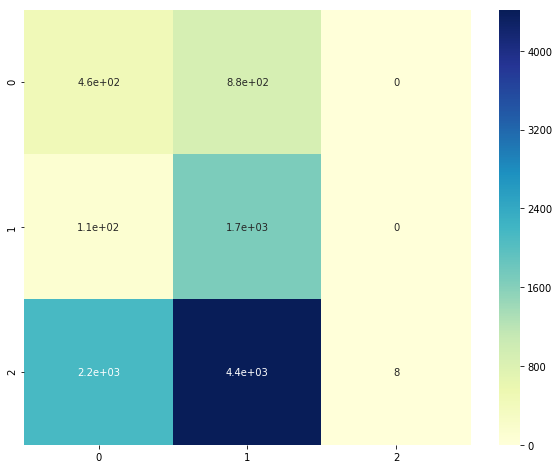

In [28]:
import seaborn as sns
import pylab as pl
pl.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, 
            cmap='YlGnBu');

In [27]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise the